In [1]:
"""
Insert all the feature names
"""

#!nrnivmodl modfiles
all_features = {'StepNeg': set(['time_constant', u'voltage_deflection_begin', 
u'voltage_base', u'voltage_deflection'
                               ]),            
            
                'StepPos':set([u'AP_duration', u'mean_frequency', u'AP_amplitude', u'fast_AHP', u'min_AHP_values',
                                u'AP_duration', 
u'mean_frequency', u'AP_amplitude', u'fast_AHP', u'min_AHP_values',
                               u'AP_amplitude_from_voltagebase', u'mean_frequency', u'AHP_depth_from_peak', 
                               u'time_to_first_spike', u'min_AHP_values',u'AP_duration', u'AP_amplitude', u'AHP1_depth_from_peak', u'AP_begin_voltage', u'time_to_first_spike', u'min_AHP_values', 
                               u'fast_AHP', u'AP2_peak', u'adaptation_index', u'AP1_begin_width', u'mean_frequency', 
                               u'min_voltage_between_spikes'
                              ])}

In [2]:
%load_ext autoreload
%autoreload

from allensdk.api.queries.biophysical_api import BiophysicalApi
%matplotlib notebook
import matplotlib.pyplot as plt
import collections

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import numpy
import json

import efel

import cell_model
import cell_evaluator

# Load the .nwb file containing the voltage traces
from allensdk.core.nwb_data_set import NwbDataSet
nwb_data = NwbDataSet('../ABI_model/data/475049288.nwb')

# Store data in a dictionary step_name:sweep_num
steps_dict = collections.OrderedDict(sorted({'StepNeg':23,'StepPos':36}.items(), key = lambda x:x[0]))

def get_data(dataset,sweeps_dict):
    # Correct for the liquid junction potential
    junction_potential = -14
    data = collections.OrderedDict()
    for step, sweep in sweeps_dict.items():
        sweep_data = {}
        # Get sweep from NWB dataset
        sweep = dataset.get_sweep(sweep)

        # Get stimulus from the sweep
        # stimulus = sweep['stimulus']

        # Sampling rate is in Hz
        sampling_rate = sweep['sampling_rate']
        
        # Start/stop indices that exclude the experimental test pulse (if applicable)
        index_range = sweep['index_range']
        
        # Response is a numpy array in mV
        sweep_data['V'] = sweep['response'][index_range[0]:index_range[1]]*1000+junction_potential    
        
        # Define some time points in milliseconds (i.e., convert to absolute time)
        sweep_data['T'] = numpy.arange(0,(len(sweep_data['V'])/sampling_rate),1./sampling_rate)*1000
        data[step] = sweep_data
    return data

data_dict = get_data(nwb_data, steps_dict)

# Extract features
    
import efel
def get_features(data, feature_names):
    
    traces_pas = []
    traces_act = []
    for step_name, step_traces in data.items():
        trace = {}
        trace['T'] = data[step_name]['T']
        trace['V'] = data[step_name]['V']
        trace['stim_start'] = [270]
        trace['stim_end'] = [1270]
        trace['name'] = step_name
    
        if 'Pos' in step_name:
            traces_act.append(trace)       
        else:
            traces_pas.append(trace)
            
    features_values = efel.getMeanFeatureValues(traces_pas, feature_names['StepNeg'])
    features_values_act = efel.getMeanFeatureValues(traces_act, feature_names['StepPos']) 
    
    features_values.extend(features_values_act)
    return features_values

efel_features = get_features(data_dict, all_features)

# Write features mean values and std in a json file
features_dict = collections.OrderedDict()
for step_name, features in zip(steps_dict.iterkeys(), efel_features):
    features_dict[step_name] = {"soma":{}}
    for name, value in features.items():
        features_dict[step_name]["soma"][name] = [value, abs(value*0.05)]    
    
with open('./config/features.json', 'w') as fp:
    json.dump(features_dict, fp, indent = 4)

In [3]:
# Score a student's dictionary of parameters

students_params = {
'Tansel': {u'Ra.axonal': 100.799,
 u'Ra.basal': 50.8833,
 u'Ra.somatic': 72.0757,
 u'celsius': 34,
 u'cm.axonal': 7.6668,
 u'cm.basal': 1.4357,
 u'cm.somatic': 2.1356,
 u'decay_CaDynamics.axonal': 811.497,
 u'decay_CaDynamics.somatic': 326.442,
 u'e_pas.axonal': -71.1766,
 u'e_pas.basal': -62.7085,
 u'e_pas.somatic': -63.3146,
 u'ek.all': -107,
 u'ena.all': 53.0,
 u'g_pas.axonal': 0.00200656,
 u'g_pas.basal': 1.10433e-07,
 u'g_pas.somatic': 7.60303e-05,
 u'gamma_CaDynamics.axonal': 0.0477399,
 u'gamma_CaDynamics.somatic': 0.00169922,
 u'gbar_Ca_HVA.axonal': 3.83558e-05,
 u'gbar_Ca_HVA.somatic': 5.9455e-05,
 u'gbar_Ca_LVA.axonal': 0.00775489,
 u'gbar_Ca_LVA.somatic': 0.0060162,
 u'gbar_Ih.basal': 7e-05,
 u'gbar_Ih.somatic': 3.46139e-06,
 u'gbar_Im_v2.basal': 0.01,
 u'gbar_K_T.axonal': 0.0013593,
 u'gbar_Kd.axonal': 0.00833495,
 u'gbar_Kv2like.axonal': 0.004970523780681963,
 u'gbar_Kv3_1.axonal': 0.0100065,
 u'gbar_Kv3_1.basal': 0.205458,
 u'gbar_Kv3_1.somatic': 0.7294,
 u'gbar_NaV.axonal': 0.01243901497054983,
 u'gbar_NaV.basal': 0.0205486,
 u'gbar_NaV.somatic': 0.04595,
 u'gbar_SK.axonal': 0.00661877,
 u'gbar_SK.somatic': 0.0001051137,
 u'v_init': -81},
'Arlindo':{u'Ra.axonal': 100.799,
  u'Ra.basal': 50.8833,
  u'Ra.somatic': 72.0757,
  u'celsius': 34,
  u'cm.axonal': 7.6668,
  u'cm.basal': 1.4357,
  u'cm.somatic': 2.1356,
  u'decay_CaDynamics.axonal': 811.497,
  u'decay_CaDynamics.somatic': 326.442,
  u'e_pas.axonal': -71.1766,
  u'e_pas.basal': -62.7085,
  u'e_pas.somatic': -63.3146,
  u'ek.all': -107,
  u'ena.all': 53.0,
  u'g_pas.axonal': 0.00200656,
  u'g_pas.basal': 1.10433e-07,
  u'g_pas.somatic': 7.60303e-05,
  u'gamma_CaDynamics.axonal': 0.0477399,
  u'gamma_CaDynamics.somatic': 0.00169922,
  u'gbar_Ca_HVA.axonal': 3.83558e-05,
  u'gbar_Ca_HVA.somatic': 5.9455e-05,
  u'gbar_Ca_LVA.axonal': 0.00775489,
  u'gbar_Ca_LVA.somatic': 0.0060162,
  u'gbar_Ih.basal': 7e-05,
  u'gbar_Ih.somatic': 3.46139e-06,
  u'gbar_Im_v2.basal': 0.01,
  u'gbar_K_T.axonal': 0.0013593,
  u'gbar_Kd.axonal': 0.00833495,
  u'gbar_Kv2like.axonal': 0.00848501700778672,
  u'gbar_Kv3_1.axonal': 0.0100065,
  u'gbar_Kv3_1.basal': 0.205458,
  u'gbar_Kv3_1.somatic': 0.7294,
  u'gbar_NaV.axonal': 0.013436510974815711,
  u'gbar_NaV.basal': 0.0205486,
  u'gbar_NaV.somatic': 0.04595,
  u'gbar_SK.axonal': 0.00661877,
  u'gbar_SK.somatic': 0.0001051137,
  u'v_init': -81},
'Luis':{u'Ra.axonal': 100.799,
u'Ra.basal': 50.8833,
u'Ra.somatic': 72.0757,
u'celsius': 34,
u'cm.axonal': 7.6668,
u'cm.basal': 1.4357,
u'cm.somatic': 2.1356,
u'decay_CaDynamics.axonal': 811.497,
u'decay_CaDynamics.somatic': 326.442,
u'e_pas.axonal': -71.1766,
u'e_pas.basal': -62.7085,
u'e_pas.somatic': -63.3146,
u'ek.all': -107,
u'ena.all': 53.0,
u'g_pas.axonal': 0.00200656,
u'g_pas.basal': 1.10433e-07,
u'g_pas.somatic': 7.60303e-05,
u'gamma_CaDynamics.axonal': 0.0477399,
u'gamma_CaDynamics.somatic': 0.00169922,
u'gbar_Ca_HVA.axonal': 3.83558e-05,
u'gbar_Ca_HVA.somatic': 5.9455e-05,
u'gbar_Ca_LVA.axonal': 0.00775489,
u'gbar_Ca_LVA.somatic': 0.0060162,
u'gbar_Ih.basal': 5.346422332836298e-05,
u'gbar_Ih.somatic': 3.46139e-06,
u'gbar_Im_v2.basal': 0.01,
u'gbar_K_T.axonal': 0.0013593,
u'gbar_Kd.axonal': 0.00833495,
u'gbar_Kv2like.axonal': 0.00848501700778672,
u'gbar_Kv3_1.axonal': 0.0100065,
u'gbar_Kv3_1.basal': 0.205458,
u'gbar_Kv3_1.somatic': 0.7294,
u'gbar_NaV.axonal': 0.013436510974815711,
u'gbar_NaV.basal': 0.0205486,
u'gbar_NaV.somatic': 0.04595,
u'gbar_SK.axonal': 0.00661877,
u'gbar_SK.somatic': 0.0001051137,
u'v_init': -81},
'Markus':    {u'Ra.axonal': 100.799,
 u'Ra.basal': 50.8833,
 u'Ra.somatic': 72.0757,
 u'celsius': 34,
 u'cm.axonal': 7.6668,
 u'cm.basal': 1.4357,
 u'cm.somatic': 2.1356,
 u'decay_CaDynamics.axonal': 811.497,
 u'decay_CaDynamics.somatic': 326.442,
 u'e_pas.axonal': -71.1766,
 u'e_pas.basal': -62.7085,
 u'e_pas.somatic': -63.3146,
 u'ek.all': -107,
 u'ena.all': 53.0,
 u'g_pas.axonal': 0.00200656,
 u'g_pas.basal': 1.10433e-07,
 u'g_pas.somatic': 7.60303e-05,
 u'gamma_CaDynamics.axonal': 0.0477399,
 u'gamma_CaDynamics.somatic': 0.00169922,
 u'gbar_Ca_HVA.axonal': 3.83558e-05,
 u'gbar_Ca_HVA.somatic': 5.9455e-05,
 u'gbar_Ca_LVA.axonal': 0.00775489,
 u'gbar_Ca_LVA.somatic': 0.0060162,
 u'gbar_Ih.basal': 7e-05,
 u'gbar_Ih.somatic': 3.46139e-06,
 u'gbar_Im_v2.basal': 0.01,
 u'gbar_K_T.axonal': 0.0013593,
 u'gbar_Kd.axonal': 0.00833495,
 u'gbar_Kv2like.axonal': 0.00692472190574025,
 u'gbar_Kv3_1.axonal': 0.022947474961030473,
 u'gbar_Kv3_1.basal': 0.5008541189680321,
 u'gbar_Kv3_1.somatic': 0.5109308141941027,
 u'gbar_NaV.axonal': 0.0011645794914983177,
 u'gbar_NaV.basal': 0.0205486,
 u'gbar_NaV.somatic': 0.04595,
 u'gbar_SK.axonal': 0.00661877,
 u'gbar_SK.somatic': 0.0001051137,
 u'v_init': -81}
                  }

results_dict = {} 
def score_all(all_params_dict):
    count = 0
    for name, params in all_params_dict.items():
        param_file = 'students_par/parameters_'+str(name)+'.json'
        with open(param_file, 'w+') as fp:
            json.dump(params, fp, indent = 4)
        
        param_configs = json.load(open(param_file))
        parameters = cell_model.define_parameters()

        morphology_file = 'Sst-IRES-Cre_Ai14_IVSCC_-183332.05.02.01_486041253_m.swc'
        morphology = ephys.morphologies.NrnFileMorphology(morphology_file, do_replace_axon=True)

        # Define mechanisms
        mechanisms = cell_model.define_mechanisms()

        # Create cell model
        abi_cell = ephys.models.CellModel('abi_cell', morph=morphology, mechs=mechanisms, params=parameters)

        # Define protocols
        proto_configs = json.load(open('config/protocols.json'))
        fitness_protocols = cell_evaluator.define_protocols()

        # Set-up a simulation and a fitness calculator
        sim = ephys.simulators.NrnSimulator()
        fitness_calculator = cell_evaluator.define_fitness_calculator(fitness_protocols)

        
        abi_cell.unfreeze(abi_cell.params)
        evaluator = ephys.evaluators.CellEvaluator(                                          
                cell_model=abi_cell,                                                       
                param_names=[],                                                    
                fitness_protocols=fitness_protocols,                                        
                fitness_calculator=fitness_calculator,                                      
                sim=sim)  

        student_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values = params)

        scores =  fitness_calculator.calculate_scores(student_responses)
        sum = numpy.sum([value for value in scores.values()])
        avg = numpy.mean([value for value in scores.values()])

        print "\nSum of all feature values: " + str(sum)
        print "Average of the feature values: " + str(avg)

        results_dict[name] = [sum, avg]
        
        count+=1
        
        print "Evaluated %d of %d students." % (count, len(students_params))
        
        
score_all(students_params)


Sum of all feature values: 115.466074433
Average of the feature values: 6.41478191292
Evaluated 1 of 4 students.

Sum of all feature values: 105.66414616
Average of the feature values: 5.87023034223
Evaluated 2 of 4 students.

Sum of all feature values: 110.837703926
Average of the feature values: 6.15765021813
Evaluated 3 of 4 students.

Sum of all feature values: 101.873002072
Average of the feature values: 5.65961122621
Evaluated 4 of 4 students.


In [4]:
sorted_results = sorted(results_dict.items(), key=lambda i: i[1][0])

print "\nThe winner is ... \n.......................................\n.......................................\n......................................."


The winner is ... 
.......................................
.......................................
.......................................


In [5]:
print "\n"+str(sorted_results[0][0])

print "\nWith a final error of %d." % sorted_results[0][1][0]


Markus

With a final error of 101.


In [6]:
print "\nAll scores...\n"
for result in sorted_results:
    print result[0], result[1][0]


All scores...

Markus 101.873002072
Tansel 105.66414616
Arlindo 110.837703926
Luis 115.466074433


<IPython.core.display.Javascript object>


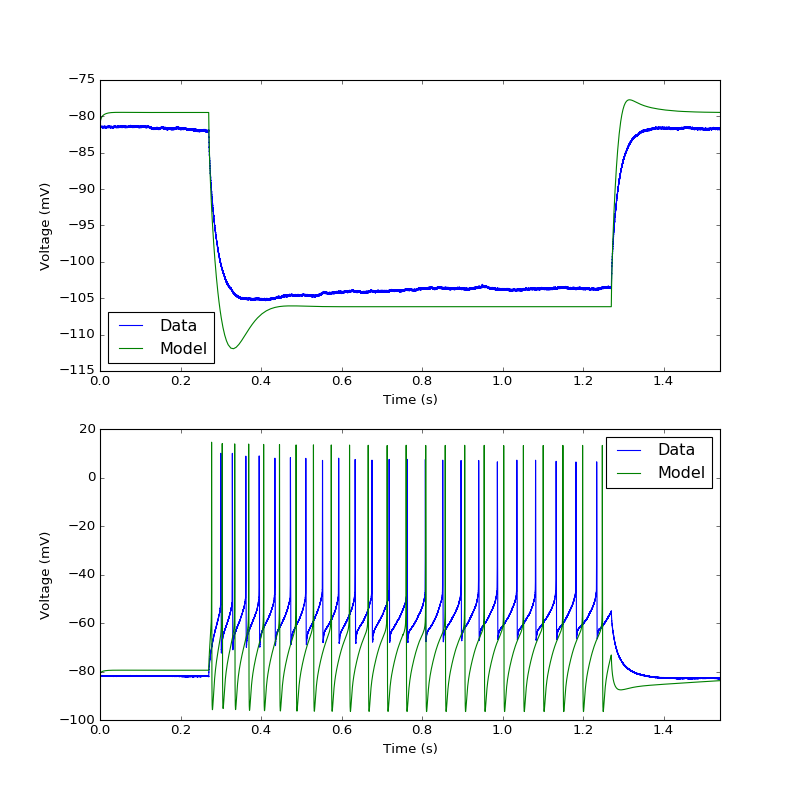

In [7]:
# Plot traces from the winner

def plot_data(sweep_data, sweeps_list, model_responses = []):
    junction_potential = -14
    fig, axes = plt.subplots(len(sweeps_list), figsize=(10,10))
    
    for index, sweep, (resp_name, model) in zip(range(len(sweeps_list)),sweeps_list, sorted(model_responses.items())):
        sweep = sweep_data.get_sweep(sweep)

        # Get stimulus from the sweep
        stimulus = sweep['stimulus']

        # Sampling rate is in Hz
        sampling_rate = sweep['sampling_rate']
        
        # Start/stop indices that exclude the experimental test pulse (if applicable)
        index_range = sweep['index_range']
        
        # Response is a numpy array in Volts
        response = sweep['response'][index_range[0]:index_range[1]]*1000    
        
        # Define some time points in seconds (i.e., convert to absolute time)
        time_pts = numpy.arange(0,(len(response)/sampling_rate),1./sampling_rate)
        

        axes[index].plot(time_pts, response+junction_potential, label = 'Data')
        axes[index].plot(model['time']/1000, model['voltage'], label = 'Model')
       
        axes[index].set_xlim([0.0, 1.54])
        axes[index].set_xlabel("Time (s)")
        axes[index].set_ylabel("Voltage (mV)")
        #axes[index].set_title(resp_name)
        axes[index].legend(loc='best')
    fig.show()
    
    
winner_configs = json.load(open('students_par/parameters_'+str(sorted_results[0][0])+'.json'))
winner_parameters = cell_model.define_parameters()

morphology_file = 'Sst-IRES-Cre_Ai14_IVSCC_-183332.05.02.01_486041253_m.swc'
morphology = ephys.morphologies.NrnFileMorphology(morphology_file, do_replace_axon=True)

# Define mechanisms
mechanisms = cell_model.define_mechanisms()

# Create cell model
abi_cell = ephys.models.CellModel('abi_cell', morph=morphology, mechs=mechanisms, params=winner_parameters)

# Define protocols
proto_configs = json.load(open('config/protocols.json'))
fitness_protocols = cell_evaluator.define_protocols()

# Set-up a simulation and a fitness calculator
sim = ephys.simulators.NrnSimulator()
fitness_calculator = cell_evaluator.define_fitness_calculator(fitness_protocols)

abi_cell.unfreeze(abi_cell.params)
evaluator = ephys.evaluators.CellEvaluator(                                          
                cell_model=abi_cell,                                                       
                param_names=[],                                                    
                fitness_protocols=fitness_protocols,                                        
                fitness_calculator=fitness_calculator,                                      
                sim=sim)  

winner_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values = winner_configs)

plot_data(nwb_data,[23, 36],winner_responses)


And above you can see the resulting traces from the winner's set of parameters.